In [2]:
%load_ext autoreload
%autoreload 2
import src.ds_utils as ds_utils
import os
import torch
import src.pytorch_datasets as pytorch_datasets
import numpy as np

import sys
import os
sys.path.append('..')
import src.svm_utils as svm_utils
import src.visualization_utils as viz_utils
import src.ds_utils as ds_utils

import seaborn as sns
sns.set()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# how to get the problematic labels: from processor.run_dict['test']['spuriouses'] 
import matplotlib.pyplot as plt

# IS THERE A BUG IN HERE? can't find...
def fraction_prob_plot(class_inds, decision_vals, confidences, is_problematic, figname, doplot=True):
    numexamples = class_inds.sum()
    # multiply by -1 if need to reverse
    
    decision_vals = decision_vals[class_inds]
    confidences = confidences[class_inds]
    is_problematic = is_problematic[class_inds]
    
    pop_level = is_problematic.mean()
    
    dv_inds = np.argsort(decision_vals)
    conf_inds = np.argsort(confidences)
    
    #print('sorted', decision_vals[dv_inds])
    
    #print('the max conf ind is problematic:',is_problematic[conf_inds[0]])
    #print('the max dv ind is problematic:',is_problematic[dv_inds[0]])
    
    dv_res = np.zeros(numexamples-1)
    cf_res = np.zeros(numexamples-1)
    for k in range(1, numexamples):
        dv_res[k-1] = (is_problematic[dv_inds[0:k]].mean())
        cf_res[k-1] = (is_problematic[conf_inds[0:k]].mean())
    #print('dv_res', dv_res)
    #print('cf_res', cf_res)
    
    if doplot:
        p=sns.lineplot(data=dv_res, color='blue')
        p=sns.lineplot(data=cf_res, color='red')
        p.axhline(pop_level,color='grey',linestyle='dashed')
        p.set_xlabel('Top K', fontsize=14)
        p.set_ylabel('Fraction Problematic', fontsize=14)

        plt.legend(labels=["SVM","Confidence", "Population Level"])
        plt.savefig('figures/' + figname + '.pdf')
        plt.show()
    
    return dv_res, cf_res
    
    #plt.plot(dv_res, color='blue')
    #plt.plot(cf_res, color='red')
    #plt.show()
    

In [62]:
svmout['train_metrics'].keys()

dict_keys(['accuracy', 'balanced_accuracy', 'confusion_matrix', 'indiv_accs', 'ytrue', 'ypred', 'decision_values', 'classes', 'skipped_classes', 'spuriouses', 'indices'])

# Colored MNIST

In [47]:
def process_svm_out(out, do_others=False):
    cv = np.mean(out['cv_scores'])
    print('Average CV score', cv)
    if do_others:
        train_acc = out['train_metrics']['accuracy']
        test_acc = out['test_metrics']['accuracy']
        
        return {'cv': cv, 'train_acc':train_acc, 'test_acc':test_acc}
    
    return cv

shared_dir = '/home/gridsan/hanlaw/CorrErrs_shared/'
rundir = shared_dir + 'experiments/cmnist/models/' #'/home/gridsan/hanlaw/CorrelatedErrors/runs/'
svmdir = shared_dir + 'experiments/cmnist/svms/' #'/home/gridsan/hanlaw/CorrelatedErrors/'

# Set this back to all levels post-debugging
corrvals = ['52','60','68','76','84','92'] #['08'] #, 16, 24, 32, 40, 48]

beton_root = "/home/gridsan/hanlaw/CorrErrs_shared/betons"
experiment_root = "/home/gridsan/hanlaw/CorrelatedErrors/"
model_root = "/home/gridsan/hanlaw/CorrErrs_shared/experiments/cmnist/models/" #os.path.join(experiment_root, "runs/")
loss_upweight_root = model_root


In [48]:

cv_vals = []
cmnistprocessors = []
for corr in corrvals:
    print('Correlation', corr)
        
    with open(svmdir + 'cmnist_svm_normalized_clip_0p' + str(corr) + '.pt', 'rb') as f:
        svmout = torch.load(f)
        cv_vals.append(process_svm_out(svmout))
        
    name = os.path.join(svmdir, f"cmnist_svm_normalized_clip_0p{corr}.pt") # SVM output file
    model_ckpt = os.path.join(model_root, f"cmnist_0p{corr}/version_0/checkpoints/checkpoint_last.pt")
     #os.path.join(experiment_root, "celeba/loss_vec_files")

    processor = viz_utils.SVMProcessor(name, root=beton_root, checkpoint_path=model_ckpt, set_device=True)
    
    processor._redo_svm(svmname=svmdir + f"cmnist_svm_normalized_clip_0p{corr}_model.pkl")
    
    cmnistprocessors.append(processor)
    
    decision_vals = processor.redo_svm['test']['test_metrics']['decision_values'] #processor.metrics['test_metrics']['decision_values'] #svmout['test_metrics']['decision_values']
    confidences = processor.run_dict['test']['confs']
    is_problematic = processor.run_dict['test']['spuriouses']
    """for c in range(2):
        class_inds = (processor.run_dict['test']['ys'] == c)
        fraction_prob_plot(class_inds, decision_vals, confidences, is_problematic, figname=f'cmnist_0p{corr}_class{c}')
    
    # display extremes for original model
    for c in range(2):
        processor.display_extremes(c, split='test', show_images=False)"""
    
        

Correlation 52
Average CV score 0.5585309572629659
-----------train_metrics--------------
{'Confusion Matrix': array([[10926,  5442],
       [16667, 14964]]),
 'Model Accuracy': 0.6589928956853268,
 'SVM Accuracy': 0.5393862128257751,
 'SVM Balanced Accuracy': 0.5703011155128479}
-----------val_metrics--------------
{'Confusion Matrix': array([[1174,  659],
       [5311, 4857]]),
 'Model Accuracy': 0.8472627281059911,
 'SVM Accuracy': 0.5025414824485779,
 'SVM Balanced Accuracy': 0.559077575802803}
-----------test_metrics--------------
{'Confusion Matrix': array([[ 6754,  3884],
       [25712, 23650]]),
 'Model Accuracy': 0.8227,
 'SVM Accuracy': 0.5067333579063416,
 'SVM Balanced Accuracy': 0.5570036321878433}
Using default mean: None
Using default std: None
Using default os_cache: False
Using default quasi_random: False
Using default train_aug: None
Using default val_aug: None
Using default loss_vec_file: None
Using default drop_last: True
Using default indices_file: None
Using defau

100%|██████████| 480/480 [00:07<00:00, 63.01it/s]


Accuracy 0.6607846021652222
---------set_device is True


100%|██████████| 121/121 [00:02<00:00, 59.25it/s]


Accuracy 0.844679594039917
---------set_device is True


100%|██████████| 600/600 [00:09<00:00, 60.34it/s]


Accuracy 0.819350004196167
================= test =====================


100%|██████████| 2/2 [02:03<00:00, 61.94s/it]


out_dict keys within predict_per_class_svm:  dict_keys(['preds', 'ys', 'spuriouses', 'latents', 'confs', 'indices'])
{   'accuracy': 0.8776666522026062,
    'balanced_accuracy': 0.6656870096921921,
    'classes': array([1, 0, 0, ..., 1, 1, 1]),
    'confusion_matrix': array([[ 3618,  7221],
       [  119, 49042]]),
    'decision_values': array([0.53172011, 1.90422889, 1.90013426, ..., 0.70989713, 0.86667586,
       0.63247592]),
    'indices': array([    0,     1,     2, ..., 59997, 59998, 59999]),
    'indiv_accs': {   'accuracy': array([0.95695513, 0.79516393]),
                      'balanced_accuracy': array([0.87293252, 0.50059941])},
    'skipped_classes': [],
    'spuriouses': array([0., 1., 0., ..., 1., 0., 0.]),
    'ypred': array([1, 1, 1, ..., 1, 1, 1]),
    'ytrue': array([1, 1, 1, ..., 1, 1, 1])}
Correlation 60
Average CV score 0.6520424198347322
-----------train_metrics--------------
{'Confusion Matrix': array([[ 8008,  7937],
       [ 9827, 22227]]),
 'Model Accuracy': 0

100%|██████████| 480/480 [00:07<00:00, 65.13it/s]


Accuracy 0.6667222380638123
---------set_device is True


100%|██████████| 121/121 [00:01<00:00, 60.98it/s]


Accuracy 0.8282642960548401
---------set_device is True


100%|██████████| 600/600 [00:09<00:00, 65.90it/s]


Accuracy 0.8046166896820068
================= test =====================


100%|██████████| 2/2 [02:01<00:00, 60.95s/it]


out_dict keys within predict_per_class_svm:  dict_keys(['preds', 'ys', 'spuriouses', 'latents', 'confs', 'indices'])
{   'accuracy': 0.6241833567619324,
    'balanced_accuracy': 0.562943622469902,
    'classes': array([1, 0, 0, ..., 1, 1, 1]),
    'confusion_matrix': array([[ 5421,  6302],
       [16247, 32030]]),
    'decision_values': array([-0.0450222 ,  0.19360391,  0.54464097, ...,  0.00445175,
        0.10872599, -0.35188324]),
    'indices': array([    0,     1,     2, ..., 59997, 59998, 59999]),
    'indiv_accs': {   'accuracy': array([0.83425939, 0.40559107]),
                      'balanced_accuracy': array([0.63679096, 0.48041081])},
    'skipped_classes': [],
    'spuriouses': array([0., 1., 1., ..., 0., 0., 1.]),
    'ypred': array([0, 1, 1, ..., 1, 1, 0]),
    'ytrue': array([0, 0, 1, ..., 0, 1, 0])}
Correlation 68
Average CV score 0.7261085777027272
-----------train_metrics--------------
{'Confusion Matrix': array([[ 8147,  7321],
       [ 7213, 25318]]),
 'Model Accurac

100%|██████████| 480/480 [00:07<00:00, 63.45it/s]


Accuracy 0.6808891892433167
---------set_device is True


100%|██████████| 121/121 [00:02<00:00, 59.42it/s]


Accuracy 0.7699358463287354
---------set_device is True


100%|██████████| 600/600 [00:09<00:00, 63.81it/s]


Accuracy 0.7553166747093201
================= test =====================


100%|██████████| 2/2 [01:56<00:00, 58.10s/it]


out_dict keys within predict_per_class_svm:  dict_keys(['preds', 'ys', 'spuriouses', 'latents', 'confs', 'indices'])
{   'accuracy': 0.3540000021457672,
    'balanced_accuracy': 0.323812872171402,
    'classes': array([1, 0, 0, ..., 1, 1, 1]),
    'confusion_matrix': array([[ 3886, 10795],
       [27965, 17354]]),
    'decision_values': array([-0.59449011,  0.14831168,  0.32697268, ...,  0.33833321,
       -0.56168657, -0.90447018]),
    'indices': array([    0,     1,     2, ..., 59997, 59998, 59999]),
    'indiv_accs': {   'accuracy': array([0.4331612 , 0.27162972]),
                      'balanced_accuracy': array([0.31524026, 0.32807489])},
    'skipped_classes': [],
    'spuriouses': array([0., 1., 0., ..., 1., 1., 0.]),
    'ypred': array([0, 1, 1, ..., 1, 0, 0]),
    'ytrue': array([1, 1, 0, ..., 0, 1, 1])}
Correlation 76
Average CV score 0.8324964836159903
-----------train_metrics--------------
{'Confusion Matrix': array([[ 7417,  4700],
       [ 4103, 31779]]),
 'Model Accurac

100%|██████████| 480/480 [00:08<00:00, 59.73it/s]


Accuracy 0.7471405863761902
---------set_device is True


100%|██████████| 121/121 [00:02<00:00, 59.22it/s]


Accuracy 0.7257728576660156
---------set_device is True


100%|██████████| 600/600 [00:09<00:00, 64.84it/s]


Accuracy 0.7255833148956299
================= test =====================


100%|██████████| 2/2 [01:04<00:00, 32.22s/it]


out_dict keys within predict_per_class_svm:  dict_keys(['preds', 'ys', 'spuriouses', 'latents', 'confs', 'indices'])
{   'accuracy': 0.8274000287055969,
    'balanced_accuracy': 0.7029432207345963,
    'classes': array([1, 0, 0, ..., 1, 1, 1]),
    'confusion_matrix': array([[ 7032,  9433],
       [  923, 42612]]),
    'decision_values': array([0.33367014, 0.22879527, 0.48876419, ..., 0.16921109, 0.52682406,
       0.65589476]),
    'indices': array([    0,     1,     2, ..., 59997, 59998, 59999]),
    'indiv_accs': {   'accuracy': array([0.85167998, 0.80213577]),
                      'balanced_accuracy': array([0.70783176, 0.69742642])},
    'skipped_classes': [],
    'spuriouses': array([0., 0., 1., ..., 0., 0., 1.]),
    'ypred': array([1, 1, 1, ..., 1, 1, 1]),
    'ytrue': array([0, 1, 1, ..., 0, 1, 1])}
Correlation 84
Average CV score 0.9916467549395376
-----------train_metrics--------------
{'Confusion Matrix': array([[ 7583,   171],
       [   97, 40148]]),
 'Model Accuracy': 0

100%|██████████| 480/480 [00:07<00:00, 62.68it/s]


Accuracy 0.8383299708366394
---------set_device is True


100%|██████████| 121/121 [00:02<00:00, 59.67it/s]


Accuracy 0.509290874004364
---------set_device is True


100%|██████████| 600/600 [00:09<00:00, 63.95it/s]


Accuracy 0.5078499913215637
================= test =====================


100%|██████████| 2/2 [00:28<00:00, 14.34s/it]


out_dict keys within predict_per_class_svm:  dict_keys(['preds', 'ys', 'spuriouses', 'latents', 'confs', 'indices'])
{   'accuracy': 0.7148500084877014,
    'balanced_accuracy': 0.713817298412323,
    'classes': array([1, 0, 0, ..., 1, 1, 1]),
    'confusion_matrix': array([[19136, 10393],
       [ 6716, 23755]]),
    'decision_values': array([-0.96715805,  0.62369266,  1.14507332, ..., -0.23188083,
       -0.75175125, -0.9420991 ]),
    'indices': array([    0,     1,     2, ..., 59997, 59998, 59999]),
    'indiv_accs': {   'accuracy': array([0.65711206, 0.77492857]),
                      'balanced_accuracy': array([0.64893013, 0.77656987])},
    'skipped_classes': [],
    'spuriouses': array([0., 0., 1., ..., 1., 1., 0.]),
    'ypred': array([0, 1, 1, ..., 0, 0, 0]),
    'ytrue': array([0, 0, 1, ..., 1, 1, 0])}
Correlation 92
Average CV score 0.9474911210745172
-----------train_metrics--------------
{'Confusion Matrix': array([[ 3449,  2141],
       [  391, 42018]]),
 'Model Accurac

100%|██████████| 480/480 [00:07<00:00, 60.67it/s]


Accuracy 0.883476734161377
---------set_device is True


100%|██████████| 121/121 [00:02<00:00, 58.25it/s]


Accuracy 0.5531205534934998
---------set_device is True


100%|██████████| 600/600 [00:09<00:00, 62.53it/s]


Accuracy 0.5549166798591614
================= test =====================


100%|██████████| 2/2 [00:38<00:00, 19.13s/it]

out_dict keys within predict_per_class_svm:  dict_keys(['preds', 'ys', 'spuriouses', 'latents', 'confs', 'indices'])
{   'accuracy': 0.8120333552360535,
    'balanced_accuracy': 0.8040163516998291,
    'classes': array([1, 0, 0, ..., 1, 1, 1]),
    'confusion_matrix': array([[19522,  7183],
       [ 4095, 29200]]),
    'decision_values': array([-0.12840928,  0.68461974, -1.25578081, ..., -0.15918503,
       -0.01283655,  0.53924149]),
    'indices': array([    0,     1,     2, ..., 59997, 59998, 59999]),
    'indiv_accs': {   'accuracy': array([0.9458099 , 0.67283362]),
                      'balanced_accuracy': array([0.94949138, 0.65021202])},
    'skipped_classes': [],
    'spuriouses': array([1., 1., 0., ..., 0., 0., 1.]),
    'ypred': array([0, 1, 0, ..., 0, 0, 1]),
    'ytrue': array([1, 1, 0, ..., 0, 0, 1])}


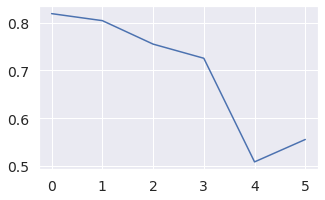

In [53]:
cmnist_spurtest_accs = []
cmnist_test_accs = []
for processor in cmnistprocessors:
    spurs = processor.run_dict['test']['spuriouses'].astype('bool')
    spur_acc = (processor.run_dict['test']['preds'][spurs] == processor.run_dict['test']['ys'][spurs]).mean()
    cmnist_spurtest_accs.append(spur_acc)
    cmnist_test_accs.append((processor.run_dict['test']['preds'] == processor.run_dict['test']['ys']).mean())
plt.plot(cmnist_test_accs)

## Make processors post-intervention

In [51]:
cmnist_intervene_processors = []
for corr in corrvals:
    print('Correlation', corr)
        
    with open(svmdir + 'cmnist_svm_normalized_clip_0p' + str(corr) + '.pt', 'rb') as f:
        svmout = torch.load(f)
        cv_vals.append(process_svm_out(svmout))
        
    name = os.path.join(svmdir, f"cmnist_svm_normalized_clip_0p{corr}.pt") # SVM output file
    model_ckpt = f'/home/gridsan/hanlaw/CorrelatedErrors/runs/cmnist_upwt_normalized_svm_0p{corr}/version_0/checkpoints/checkpoint_last.pt'
     #os.path.join(experiment_root, "celeba/loss_vec_files")

    processor = viz_utils.SVMProcessor(name, root=beton_root, checkpoint_path=model_ckpt, set_device=True)
    
    #processor._redo_svm(svmname=svmdir + f"cmnist_svm_normalized_clip_0p{corr}_model.pkl")
    
    cmnist_intervene_processors.append(processor)
    
    

Correlation 52
Average CV score 0.5585309572629659
-----------train_metrics--------------
{'Confusion Matrix': array([[10926,  5442],
       [16667, 14964]]),
 'Model Accuracy': 0.6589928956853268,
 'SVM Accuracy': 0.5393862128257751,
 'SVM Balanced Accuracy': 0.5703011155128479}
-----------val_metrics--------------
{'Confusion Matrix': array([[1174,  659],
       [5311, 4857]]),
 'Model Accuracy': 0.8472627281059911,
 'SVM Accuracy': 0.5025414824485779,
 'SVM Balanced Accuracy': 0.559077575802803}
-----------test_metrics--------------
{'Confusion Matrix': array([[ 6754,  3884],
       [25712, 23650]]),
 'Model Accuracy': 0.8227,
 'SVM Accuracy': 0.5067333579063416,
 'SVM Balanced Accuracy': 0.5570036321878433}
Using default mean: None
Using default std: None
Using default os_cache: False
Using default quasi_random: False
Using default train_aug: None
Using default val_aug: None
Using default loss_vec_file: None
Using default drop_last: True
Using default indices_file: None
Using defau

100%|██████████| 480/480 [00:08<00:00, 56.53it/s]


Accuracy 0.667388916015625
---------set_device is True


100%|██████████| 121/121 [00:02<00:00, 58.12it/s]


Accuracy 0.849679172039032
---------set_device is True


100%|██████████| 600/600 [00:09<00:00, 62.37it/s]


Accuracy 0.8321833610534668
Correlation 60
Average CV score 0.6520424198347322
-----------train_metrics--------------
{'Confusion Matrix': array([[ 8008,  7937],
       [ 9827, 22227]]),
 'Model Accuracy': 0.6678055792829017,
 'SVM Accuracy': 0.6299089789390564,
 'SVM Balanced Accuracy': 0.5978249907493591}
-----------val_metrics--------------
{'Confusion Matrix': array([[1471,  619],
       [3958, 5953]]),
 'Model Accuracy': 0.8258478460128322,
 'SVM Accuracy': 0.6186150908470154,
 'SVM Balanced Accuracy': 0.6522367298603058}
-----------test_metrics--------------
{'Confusion Matrix': array([[ 7729,  4010],
       [19390, 28871]]),
 'Model Accuracy': 0.80435,
 'SVM Accuracy': 0.6100000143051147,
 'SVM Balanced Accuracy': 0.6283149719238281}
Using default mean: None
Using default std: None
Using default os_cache: False
Using default quasi_random: False
Using default train_aug: None
Using default val_aug: None
Using default loss_vec_file: None
Using default drop_last: True
Using default 

100%|██████████| 480/480 [00:08<00:00, 59.31it/s]


Accuracy 0.6622012853622437
---------set_device is True


100%|██████████| 121/121 [00:02<00:00, 55.87it/s]


Accuracy 0.8116823434829712
---------set_device is True


100%|██████████| 600/600 [00:09<00:00, 63.37it/s]


Accuracy 0.7936333417892456
Correlation 68
Average CV score 0.7261085777027272
-----------train_metrics--------------
{'Confusion Matrix': array([[ 8147,  7321],
       [ 7213, 25318]]),
 'Model Accuracy': 0.6777432863184649,
 'SVM Accuracy': 0.6972020268440247,
 'SVM Balanced Accuracy': 0.652486652135849}
-----------val_metrics--------------
{'Confusion Matrix': array([[2324,  413],
       [3677, 5587]]),
 'Model Accuracy': 0.771935672027331,
 'SVM Accuracy': 0.659195065498352,
 'SVM Balanced Accuracy': 0.7260960638523102}
-----------test_metrics--------------
{'Confusion Matrix': array([[11881,  2791],
       [18119, 27209]]),
 'Model Accuracy': 0.7554666666666666,
 'SVM Accuracy': 0.6514999866485596,
 'SVM Balanced Accuracy': 0.7050214409828186}
Using default mean: None
Using default std: None
Using default os_cache: False
Using default quasi_random: False
Using default train_aug: None
Using default val_aug: None
Using default loss_vec_file: None
Using default drop_last: True
Using 

100%|██████████| 480/480 [00:08<00:00, 58.24it/s]


Accuracy 0.6840559244155884
---------set_device is True


100%|██████████| 121/121 [00:02<00:00, 57.93it/s]


Accuracy 0.7794350385665894
---------set_device is True


100%|██████████| 600/600 [00:10<00:00, 59.33it/s]


Accuracy 0.763533353805542
Correlation 76
Average CV score 0.8324964836159903
-----------train_metrics--------------
{'Confusion Matrix': array([[ 7417,  4700],
       [ 4103, 31779]]),
 'Model Accuracy': 0.7475572407758495,
 'SVM Accuracy': 0.8166003227233887,
 'SVM Balanced Accuracy': 0.7488840818405151}
-----------val_metrics--------------
{'Confusion Matrix': array([[3204,   55],
       [2797, 5945]]),
 'Model Accuracy': 0.7284392967252729,
 'SVM Accuracy': 0.7623531222343445,
 'SVM Balanced Accuracy': 0.8315869867801666}
-----------test_metrics--------------
{'Confusion Matrix': array([[16073,   435],
       [13927, 29565]]),
 'Model Accuracy': 0.7248666666666667,
 'SVM Accuracy': 0.7606333494186401,
 'SVM Balanced Accuracy': 0.8267146646976471}
Using default mean: None
Using default std: None
Using default os_cache: False
Using default quasi_random: False
Using default train_aug: None
Using default val_aug: None
Using default loss_vec_file: None
Using default drop_last: True
Usin

100%|██████████| 480/480 [00:07<00:00, 61.41it/s]


Accuracy 0.7243692874908447
---------set_device is True


100%|██████████| 121/121 [00:02<00:00, 57.76it/s]


Accuracy 0.7159403562545776
---------set_device is True


100%|██████████| 600/600 [00:09<00:00, 63.50it/s]


Accuracy 0.7104833126068115
Correlation 84
Average CV score 0.9916467549395376
-----------train_metrics--------------
{'Confusion Matrix': array([[ 7583,   171],
       [   97, 40148]]),
 'Model Accuracy': 0.8384549678118294,
 'SVM Accuracy': 0.9944165349006653,
 'SVM Balanced Accuracy': 0.9877683222293854}
-----------val_metrics--------------
{'Confusion Matrix': array([[5898,    0],
       [ 103, 6000]]),
 'Model Accuracy': 0.5085409549204233,
 'SVM Accuracy': 0.991417407989502,
 'SVM Balanced Accuracy': 0.9915615320205688}
-----------test_metrics--------------
{'Confusion Matrix': array([[29495,     1],
       [  505, 29999]]),
 'Model Accuracy': 0.5084,
 'SVM Accuracy': 0.9915666580200195,
 'SVM Balanced Accuracy': 0.991705447435379}
Using default mean: None
Using default std: None
Using default os_cache: False
Using default quasi_random: False
Using default train_aug: None
Using default val_aug: None
Using default loss_vec_file: None
Using default drop_last: True
Using default ind

100%|██████████| 480/480 [00:07<00:00, 60.24it/s]


Accuracy 0.8343715667724609
---------set_device is True


100%|██████████| 121/121 [00:02<00:00, 58.05it/s]


Accuracy 0.5280393362045288
---------set_device is True


100%|██████████| 600/600 [00:09<00:00, 63.09it/s]


Accuracy 0.5268833041191101
Correlation 92
Average CV score 0.9474911210745172
-----------train_metrics--------------
{'Confusion Matrix': array([[ 3449,  2141],
       [  391, 42018]]),
 'Model Accuracy': 0.8835392404008416,
 'SVM Accuracy': 0.9472488760948181,
 'SVM Balanced Accuracy': 0.8038874268531799}
-----------val_metrics--------------
{'Confusion Matrix': array([[5346,   33],
       [ 655, 5967]]),
 'Model Accuracy': 0.5517873510540788,
 'SVM Accuracy': 0.9426714181900024,
 'SVM Balanced Accuracy': 0.9474761486053467}
-----------test_metrics--------------
{'Confusion Matrix': array([[26078,   518],
       [ 3922, 29482]]),
 'Model Accuracy': 0.5567333333333333,
 'SVM Accuracy': 0.9259999990463257,
 'SVM Balanced Accuracy': 0.9315561652183533}
Using default mean: None
Using default std: None
Using default os_cache: False
Using default quasi_random: False
Using default train_aug: None
Using default val_aug: None
Using default loss_vec_file: None
Using default drop_last: True
Usi

100%|██████████| 480/480 [00:07<00:00, 61.48it/s]


Accuracy 0.8845809102058411
---------set_device is True


100%|██████████| 121/121 [00:02<00:00, 56.59it/s]


Accuracy 0.5504541397094727
---------set_device is True


100%|██████████| 600/600 [00:10<00:00, 59.67it/s]


Accuracy 0.5540500283241272


/home/gridsan/hanlaw/.conda/envs/ffcv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/gridsan/hanlaw/.conda/envs/ffcv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


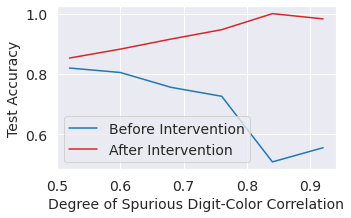

In [62]:
cmnist_intervene_spurtest_accs = []
cmnist_intervene_test_accs = []
for processor in cmnist_intervene_processors:
    spurs = processor.run_dict['test']['spuriouses'].astype('bool')
    spur_acc = (processor.run_dict['test']['preds'][spurs] == processor.run_dict['test']['ys'][spurs]).mean()
    cmnist_intervene_spurtest_accs.append(spur_acc)
    cmnist_intervene_test_accs.append((processor.run_dict['test']['preds'] == processor.run_dict['test']['ys']).mean())
p=sns.lineplot([float(i)/100 for i in corrvals],cmnist_test_accs,color=BLUE)
p=sns.lineplot([float(i)/100 for i in corrvals],cmnist_intervene_spurtest_accs,color=RED)
#plt.legend()

#p = sns.lineplot([float(i)/100 for i in corrvals],cv_vals, color=BLUE)
#p = sns.lineplot(range(1,9),celeba_validation_model_accs, color=GREEN)

p.set_xlabel('Degree of Spurious Digit-Color Correlation', fontsize=14)
p.set_ylabel('Test Accuracy', fontsize=14)
plt.legend(labels=["Before Intervention", "After Intervention"], fontsize=14)
#plt.show()
plt.savefig('cmnist_test_acc_intervention.pdf', bbox_inches='tight')

plt.show()



In [39]:
processor.run_dict['test'].keys()

dict_keys(['preds', 'ys', 'spuriouses', 'latents', 'confs', 'indices'])

In [41]:
processor.run_dict['test']['spuriouses'].astype('bool')

array([ True,  True, False, ...,  True, False,  True])

In [15]:
processor.redo_svm['test']['test_metrics']

{'accuracy': 0.812250018119812,
 'balanced_accuracy': 0.8041451871395111,
 'confusion_matrix': array([[19494,  7142],
        [ 4123, 29241]]),
 'indiv_accs': {'accuracy': array([0.94348937, 0.67569035]),
  'balanced_accuracy': array([0.94718242, 0.65211992])},
 'ytrue': array([0, 0, 1, ..., 1, 1, 1]),
 'ypred': array([0, 0, 1, ..., 0, 1, 1]),
 'decision_values': array([-0.53780274, -0.2799321 ,  1.36006921, ..., -0.1594172 ,
         0.17680841,  0.53924149]),
 'classes': array([1, 0, 0, ..., 1, 1, 1]),
 'skipped_classes': [],
 'spuriouses': array([0., 0., 1., ..., 1., 1., 1.]),
 'indices': array([    0,     1,     2, ..., 59997, 59998, 59999])}

the max conf ind is problematic: 1.0
the max dv ind is problematic: 1.0


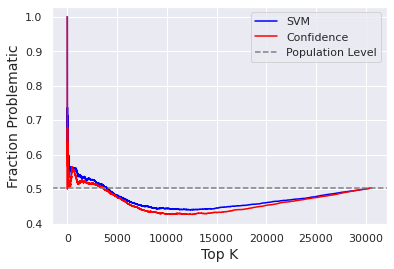

the max conf ind is problematic: 0.0
the max dv ind is problematic: 1.0


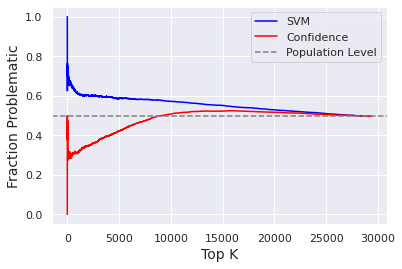

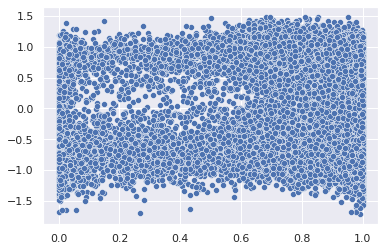

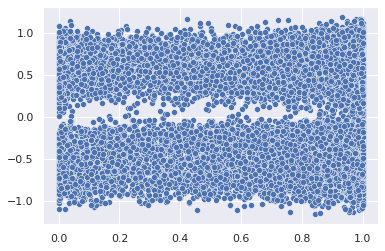

In [12]:
for c in range(2):
    class_inds = (processor.run_dict['test']['ys'] == c)
    fraction_prob_plot(class_inds, decision_vals, confidences, is_problematic, figname=f'cmnist_0p{corr}_class{c}')

# display extremes for original model
for c in range(2):
    processor.display_extremes(c, split='test', show_images=False)
    
        

In [7]:
processor.redo_svm['test']['test_metrics']['decision_values'].shape

(60000,)

In [37]:
cv_vals

[0.5585309572629659,
 0.6520424198347322,
 0.7261085777027272,
 0.8324964836159903,
 0.9916467549395376,
 0.9474911210745172]

/home/gridsan/hanlaw/.conda/envs/ffcv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


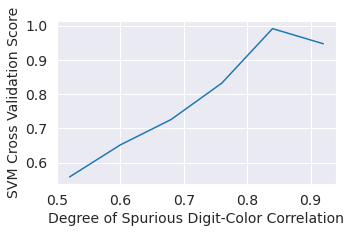

In [61]:
p = sns.lineplot([float(i)/100 for i in corrvals],cv_vals, color=BLUE)
#p = sns.lineplot(range(1,9),celeba_validation_model_accs, color=GREEN)

p.set_xlabel('Degree of Spurious Digit-Color Correlation')
p.set_ylabel('SVM Cross Validation Score')
#plt.show()
plt.savefig('cmnist_cv_plot.pdf', bbox_inches='tight')
plt.show()

In [47]:
import yaml
from src.config_parsing import ffcv_read_check_override_config 

config_file = 'dataset_configs/cmnist/cmnist_0p08.yaml'
with open(config_file, 'r') as file:
    hparams = yaml.safe_load(file)
hparams = ffcv_read_check_override_config(hparams)
#train, val, test = get_training_loaders(hparams, pipeline_subset=['image', 'label', 'index'], 

#get_unlabeled=False, root="/mnt/cfs/projects/correlated_errors/betons",
#                         indices_dict=None)

Using default mean: None
Using default std: None
Using default os_cache: False
Using default quasi_random: True
Using default train_aug: None
Using default val_aug: None
Using default loss_vec_file: None
Using default drop_last: True
Using default indices_file: None
Using default val_beton: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False


# Celeb A, age

## Full dataset

In [16]:
name = '/home/gridsan/hanlaw/CorrErrs_shared/experiments/celeba/celeba_normalized/svm_checkpoint/celeba_age_full_normalized_svm.pt' #os.path.join(experiment_root, f"celeba_age_full_svm.pt") # SVM output file
model_ckpt = os.path.join("/home/gridsan/hanlaw/CorrErrs_shared/experiments/celeba/celeba_normalized/models/", f"celeba_age_full_base/version_0/checkpoints/checkpoint_last.pt")

celebaprocessor = viz_utils.SVMProcessor(name, root=beton_root, checkpoint_path=model_ckpt, set_device=True, spurious=True)
    

-----------train_metrics--------------
{'Confusion Matrix': array([[    26,      3],
       [ 50474, 112267]]),
 'Model Accuracy': 0.9998218344903852,
 'SVM Accuracy': 0.6898875832557678,
 'SVM Balanced Accuracy': 0.7932012379169464}
-----------val_metrics--------------
{'Confusion Matrix': array([[ 2506,   402],
       [ 3797, 13162]]),
 'Model Accuracy': 0.8536266170030704,
 'SVM Accuracy': 0.7886444926261902,
 'SVM Balanced Accuracy': 0.8189338743686676}
-----------test_metrics--------------
{'Confusion Matrix': array([[ 2290,   624],
       [ 3935, 13113]]),
 'Model Accuracy': 0.8540226430217414,
 'SVM Accuracy': 0.7716160416603088,
 'SVM Balanced Accuracy': 0.7775212526321411}
Using default os_cache: False
Using default quasi_random: False
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Using default cmnist: False

-----------CONFIG------------

100%|██████████| 1628/1628 [00:16<00:00, 99.97it/s] 


Accuracy 0.9998157024383545
---------set_device is True


100%|██████████| 199/199 [00:02<00:00, 91.12it/s] 


Accuracy 0.8535259366035461
---------set_device is True


100%|██████████| 200/200 [00:02<00:00, 88.74it/s] 

Accuracy 0.8540727496147156


In [25]:
celebaprocessor._redo_svm(svmname='/home/gridsan/hanlaw/CorrErrs_shared/experiments/celeba/celeba_normalized/svm_checkpoint/celeba_age_full_normalized_svm_model.pkl')





================= test =====================


100%|██████████| 2/2 [01:07<00:00, 33.96s/it]


out_dict keys within predict_per_class_svm:  dict_keys(['preds', 'ys', 'spuriouses', 'latents', 'confs', 'indices'])
{   'accuracy': 0.1892595887184143,
    'balanced_accuracy': 0.35316433757543564,
    'classes': array([0, 1, 1, ..., 1, 1, 1]),
    'confusion_matrix': array([[ 1703,  1210],
       [14974,  2075]]),
    'decision_values': array([-13.53624512,  -0.94692442,   0.23615291, ...,  -1.21797014,
         4.22680868,  -6.81869883]),
    'indices': array([    0,     1,     2, ..., 19959, 19960, 19961]),
    'indiv_accs': {   'accuracy': array([0.34075907, 0.14066428]),
                      'balanced_accuracy': array([0.42722793, 0.09989979])},
    'skipped_classes': [],
    'spuriouses': array([0, 0, 0, ..., 1, 0, 0]),
    'ypred': array([0, 0, 1, ..., 0, 1, 0]),
    'ytrue': array([1, 1, 1, ..., 1, 0, 1])}


In [28]:
celebaprocessor.run_dict['test']['spuriouses']

array([0, 0, 0, ..., 1, 0, 0])

NOT 50 examples 0 4848
dv_curve (4847,)


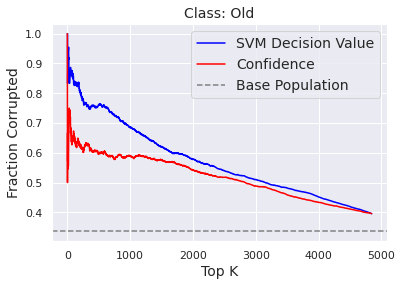

NOT 50 examples 1 15114
dv_curve (15113,)


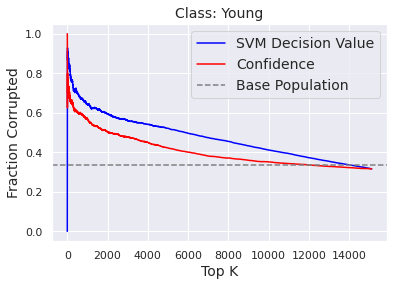

In [56]:
decision_vals = celebaprocessor.metrics['test_metrics']['decision_values'] #celebaprocessor.redo_svm['test']['test_metrics']['decision_values'] # #svmout['test_metrics']['decision_values']
confidences = celebaprocessor.run_dict['test']['confs']
is_problematic = true_spurs #celebaprocessor.run_dict['test']['spuriouses']
# why do they ALWAYS start from 0??
dv_curves=[]
cf_curves=[]
class_to_name = {'0':'Old', '1':'Young'}

for c in range(2):
    class_inds = (celebaprocessor.run_dict['test']['ys'] == c) # | (celebaprocessor.run_dict['test']['ys'] == 1)
    if (class_inds.sum()) != 50:
        print('NOT 50 examples', c, class_inds.sum())
    dv_curve, cf_curve = fraction_prob_plot(class_inds, decision_vals, confidences, \
                                            is_problematic, figname=f'imagenetc_class_{c}',doplot=False)
    print('dv_curve', dv_curve.shape)
    dv_curves.append(dv_curve)
    cf_curves.append(cf_curve)
    
    p=sns.lineplot(data=dv_curve, color='blue')
    p=sns.lineplot(data=cf_curve, color='red')
    p.axhline(is_problematic.mean(),color='grey',linestyle='dashed')
    p.set_xlabel('Top K', fontsize=14)
    p.set_ylabel('Fraction Corrupted', fontsize=14)
    p.set_title(f'Class: {class_to_name[str(c)]}', fontsize=14)

    plt.legend(labels=["SVM Decision Value","Confidence", "Base Population"],fontsize=14)
    plt.savefig(f'figures/full_celeba_frack_{class_to_name[str(c)]}.pdf', bbox_inches='tight')
    plt.show()

    



In [32]:
celebaprocessor.run_dict['test']

{'preds': array([0, 1, 1, ..., 1, 0, 1]),
 'ys': array([0, 1, 1, ..., 1, 1, 1]),
 'spuriouses': array([0, 0, 0, ..., 1, 0, 0]),
 'latents': array([[0.6597 , 0.377  , 0.8774 , ..., 0.223  , 0.094  , 0.681  ],
        [0.202  , 0.0911 , 0.194  , ..., 0.4368 , 0.2793 , 0.2373 ],
        [0.4749 , 0.2854 , 0.719  , ..., 0.2404 , 0.3938 , 0.3618 ],
        ...,
        [0.7295 , 0.3516 , 0.3098 , ..., 0.3364 , 0.3093 , 0.07837],
        [0.608  , 0.4106 , 0.5728 , ..., 0.1863 , 0.2554 , 0.4614 ],
        [0.5464 , 0.4465 , 0.3303 , ..., 0.935  , 1.098  , 0.631  ]],
       dtype=float16),
 'confs': array([0.99998796, 0.9976357 , 0.8362205 , ..., 0.9977569 , 0.42772537,
        1.        ], dtype=float32),
 'indices': array([    0,     1,     2, ..., 19959, 19960, 19961])}

In [40]:
celebaprocessor.metrics['test_metrics']

{'accuracy': 0.7716160416603088,
 'balanced_accuracy': 0.7775212526321411,
 'confusion_matrix': array([[ 2290,   624],
        [ 3935, 13113]]),
 'indiv_accs': {'accuracy': array([0.78052807, 0.76875746]),
  'balanced_accuracy': array([0.78028747, 0.78291497])},
 'ytrue': array([1, 1, 1, ..., 1, 0, 1]),
 'ypred': array([1, 1, 1, ..., 0, 1, 1]),
 'decision_values': array([ 1.61870329,  0.14199784,  0.46937321, ..., -0.63300073,
         0.91447111,  0.24764337]),
 'classes': array([0, 1, 1, ..., 1, 1, 1]),
 'skipped_classes': [],
 'spuriouses': None,
 'indices': array([    0,     1,     2, ..., 19959, 19960, 19961])}

In [41]:
celebaprocessor.metrics['test_metrics']['ytrue'].mean()

0.8540226430217414

In [46]:
celebaprocessor.metrics['test_metrics']['ytrue'].shape[0] - (celebaprocessor.metrics['test_metrics']['ytrue'] == \
(celebaprocessor.run_dict['test']['ys'] == celebaprocessor.run_dict['test']['preds'])).sum()

3

In [42]:
(celebaprocessor.run_dict['test']['ys'] == celebaprocessor.run_dict['test']['preds']).mean()

0.8540727382025849

In [39]:
celebaprocessor.redo_svm['test']['test_metrics']

{'accuracy': 0.1892595887184143,
 'balanced_accuracy': 0.35316433757543564,
 'confusion_matrix': array([[ 1703,  1210],
        [14974,  2075]]),
 'indiv_accs': {'accuracy': array([0.34075907, 0.14066428]),
  'balanced_accuracy': array([0.42722793, 0.09989979])},
 'ytrue': array([1, 1, 1, ..., 1, 0, 1]),
 'ypred': array([0, 0, 1, ..., 0, 1, 0]),
 'decision_values': array([-13.53624512,  -0.94692442,   0.23615291, ...,  -1.21797014,
          4.22680868,  -6.81869883]),
 'classes': array([0, 1, 1, ..., 1, 1, 1]),
 'skipped_classes': [],
 'spuriouses': array([0, 0, 0, ..., 1, 0, 0]),
 'indices': array([    0,     1,     2, ..., 19959, 19960, 19961])}

In [33]:
celebaprocessor.run_dict['test']['spuriouses'].mean()

0.38648432020839596

In [49]:
(celebaprocessor.run_dict['test']['spuriouses'] == celebaprocessor.redo_svm['test']['test_metrics']['spuriouses']).mean()

1.0

In [44]:
celebaprocessor.run_dict['test'].keys()

dict_keys(['preds', 'ys', 'spuriouses', 'latents', 'confs', 'indices'])

In [47]:
spurs.mean()

0.31646155881963745

In [53]:
((males & youngs) | (np.logical_not(males) & np.logical_not(youngs))).shape

(19962,)

In [54]:
#SANITY??

predicted_wrong = (celebaprocessor.metrics['test_metrics']['ypred'] == 0)
actually_wrong = (celebaprocessor.run_dict['test']['ys'] != celebaprocessor.run_dict['test']['preds'])
spurs = celebaprocessor.run_dict['test']['spuriouses']

# spurs: 0 is female, 1 is male?? could that be it?
males = celebaprocessor.run_dict['test']['spuriouses']
youngs = celebaprocessor.run_dict['test']['ys']
true_spurs = (males & youngs) | (np.logical_not(males) & np.logical_not(youngs))

print('fraction of spurious in dataset', spurs.mean())
print('error fraction on test set of base model', actually_wrong.mean())
print('spurious rate of actual errors', spurs[actually_wrong].mean())
print('spurious rate of predicted errors', spurs[predicted_wrong].mean())

#0 is female, 1 is male


for c in range(2):
    print('\n Class', c)
    class_inds = (celebaprocessor.run_dict['test']['ys'] == c)
    print('representation in dataset', class_inds.mean())
    predicted_wrong = (celebaprocessor.metrics['test_metrics']['ypred'][class_inds] == 0)
    actually_wrong = (celebaprocessor.run_dict['test']['ys'] != celebaprocessor.run_dict['test']['preds'])[class_inds]
    spurs = true_spurs[class_inds] #celebaprocessor.run_dict['test']['spuriouses'][class_inds]
    print('spurious rate for this class', spurs.mean())
    print('error rate on test set of base model', actually_wrong.mean())
    print('spurious rate of actual errors', spurs[actually_wrong].mean())
    print('spurious rate of predicted errors', spurs[predicted_wrong].mean())

fraction of spurious in dataset 0.38648432020839596
error fraction on test set of base model 0.14592726179741508
spurious rate of actual errors 0.4905595605904566
spurious rate of predicted errors 0.5037751004016064

 Class 0
representation in dataset 0.2428614367297866
spurious rate for this class 0.3952145214521452
error rate on test set of base model 0.3987211221122112
spurious rate of actual errors 0.5504397309881014
spurious rate of predicted errors 0.5655622958469435

 Class 1
representation in dataset 0.7571385632702134
spurious rate for this class 0.31646155881963745
error rate on test set of base model 0.06484054518989017
spurious rate of actual errors 0.5714285714285714
spurious rate of predicted errors 0.5401763841254287


In [38]:
celebaprocessor.run_dict['test']['spuriouses'][predicted_wrong].mean()

0.6734274711168164

In [31]:
(celebaprocessor.run_dict['test']['preds'] == celebaprocessor.run_dict['test']['ys']).mean()

0.8540727382025849

In [16]:
is_problematic

array([0, 0, 0, ..., 1, 0, 0])

In [27]:
(((decision_vals < 0).astype('float')) == is_problematic).mean()

0.4122833383428514

In [10]:
p=sns.lineplot(data=np.mean(np.array(dv_curves), 0), color='blue')
p=sns.lineplot(data=np.mean(np.array(cf_curves), 0), color='red')
p.axhline(is_problematic.mean(),color='grey',linestyle='dashed')
p.set_xlabel('Top K', fontsize=14)
p.set_ylabel('Fraction Corrupted', fontsize=14)

plt.legend(labels=["SVM Score","Confidence", "Base Population"],fontsize=14)
#plt.savefig('figures/imagenetc_frack.pdf', bbox_inches='tight')
plt.show()


/state/partition1/slurm_tmp/18017574.0.0/ipykernel_72505/2452750262.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p=sns.lineplot(data=np.mean(np.array(dv_curves), 0), color='blue')


ValueError: operands could not be broadcast together with shapes (4847,) (15113,) 

In [84]:
# Get cross val scores 
def check_efficacy(split='test', is_correct=None):
    age = celebaprocessor.metrics[f'{split}_metrics']['classes'] # 0 if female, 1 if male
    gender = celebaprocessor.run_dict[split]['spuriouses']
    #processor.metrics[f'{split}_metrics']['spuriouses'] #1 if blond, 2 if black hair, 0 if neither
    if is_correct is None:
        is_correct = celebaprocessor.metrics[f'{split}_metrics']['ytrue']
    age_masks = {
        'old': age == 0,
        'young': age == 1,
    }
    gender_masks = {
        'female': gender == 0,
        'male': gender == 1
    }
    for a, a_m in age_masks.items():
        for g, g_m in gender_masks.items():
            print(f"{a}, {g}, {is_correct[g_m & a_m].mean():0.4f}, {len(is_correct[g_m & a_m])}")
    return age_masks, gender_masks


In [85]:
print("val")
test_masks = check_efficacy("val")
print("\ntest")
test_masks = check_efficacy("test")
print("\ntrain")
train_masks = check_efficacy("train")

val
old, female, 0.4490, 1795
old, male, 0.6932, 3240
young, female, 0.9611, 9614
young, male, 0.8944, 5218

test
old, female, 0.4447, 1916
old, male, 0.7036, 2932
young, female, 0.9593, 10331
young, male, 0.8827, 4783

train
old, female, 0.9996, 11167
old, male, 0.9996, 24815
young, female, 1.0000, 83342
young, male, 0.9998, 43446


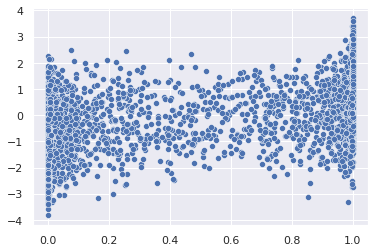

---- CONFIDENCE ------


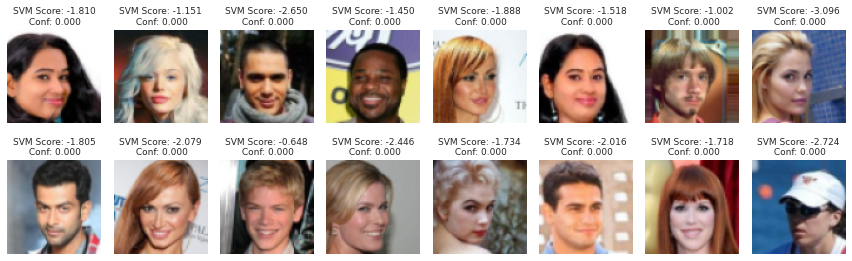

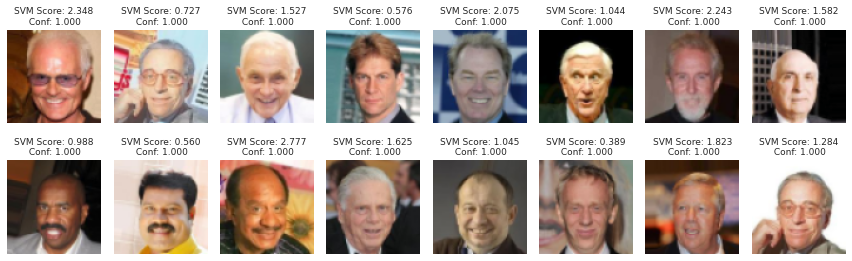

---- SVM ------


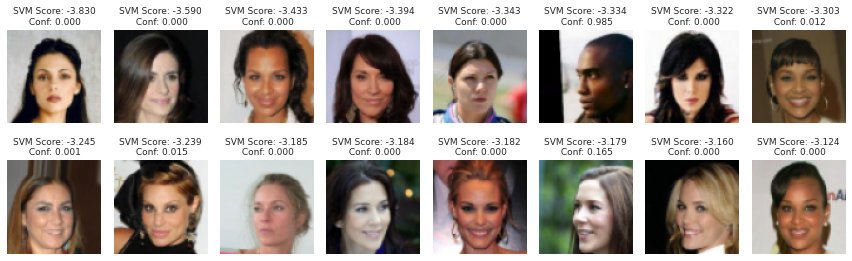

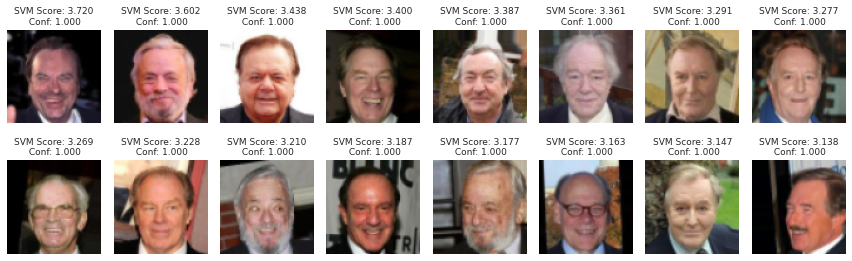

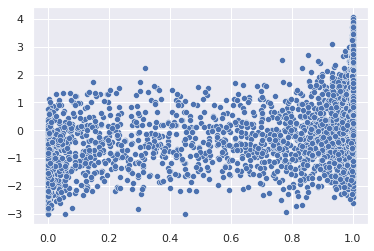

---- CONFIDENCE ------


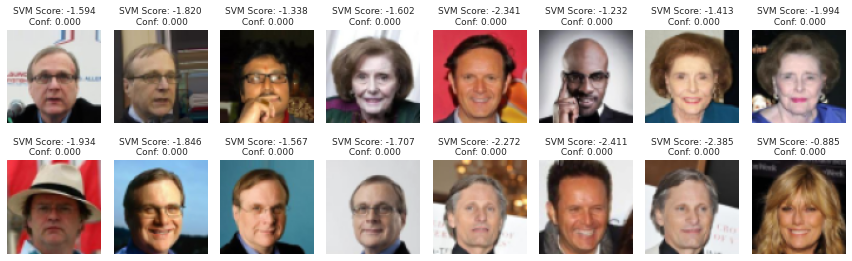

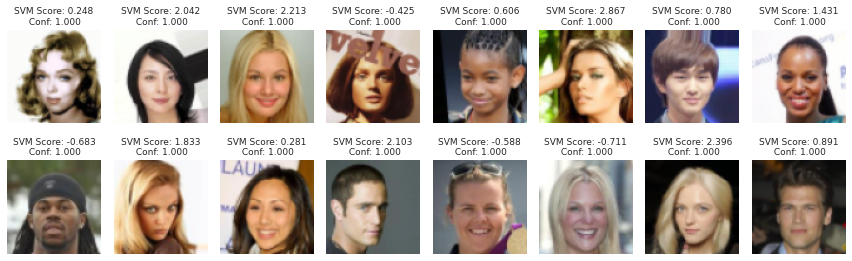

---- SVM ------


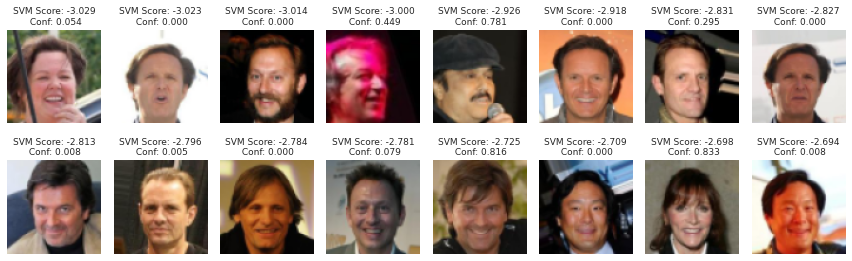

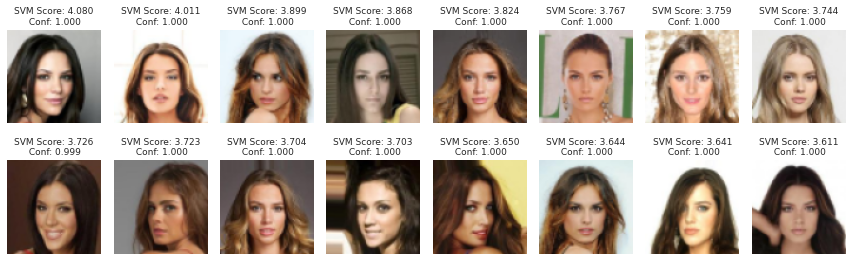

In [56]:
# display extremes for original model
for c in range(2):
    celebaprocessor.display_extremes(c, split='test')

## make top k plots

### Check efficacy of interventions

In [128]:
# oracle
fix = torch.load('runs/celeba_age_full_upwt_oracle2_int/version_1/metrics.pt')
for split in ['val', 'test']:
    print(f"{split}")
    print(f"Accuracy {fix[split]['Accuracy']:0.4f}")
    intervene_is_correct = (fix[split]['classes'] == fix[split]['preds']).float()
    check_efficacy(split, intervene_is_correct.numpy())

val
Accuracy 0.8516
old, female, 0.4418, 1795
old, male, 0.6787, 3240
young, female, 0.9612, 9614
young, male, 0.8979, 5218
test
Accuracy 0.8548
old, female, 0.4462, 1916
old, male, 0.6999, 2932
young, female, 0.9600, 10331
young, male, 0.8861, 4783


In [131]:
# svm
fix = torch.load('runs/celeba_age_full_upwt_svm2_int2/version_0/metrics.pt')
for split in ['val', 'test']:
    print(f"{split}")
    print(f"Accuracy {fix[split]['Accuracy']:0.4f}")
    intervene_is_correct = (fix[split]['classes'] == fix[split]['preds']).float()
    check_efficacy(split, intervene_is_correct.numpy())

val
Accuracy 0.8498
old, female, 0.4535, 1795
old, male, 0.6796, 3240
young, female, 0.9591, 9614
young, male, 0.8904, 5218
test
Accuracy 0.8544
old, female, 0.4530, 1916
old, male, 0.7087, 2932
young, female, 0.9596, 10331
young, male, 0.8771, 4783


## Overlapping spurious correlations

In [39]:
name = '/home/gridsan/hanlaw/CorrErrs_shared/experiments/celeba/celeba_normalized/svm_checkpoint/celeba_1_4.pt' #os.path.join(experiment_root, f"celeba_age_full_svm.pt") # SVM output file
model_ckpt = '/home/gridsan/hanlaw/CorrErrs_shared/experiments/celeba/celeba_normalized/models/celeba_age_1_4/version_0/checkpoints/checkpoint_last.pt' #os.path.join(model_root, f"celeba_age_full_base/version_0/checkpoints/checkpoint_last.pt")

cbprocessor = viz_utils.SVMProcessor(name, root=beton_root, checkpoint_path=model_ckpt, set_device=True, spurious=True)
    

-----------train_metrics--------------
{'Confusion Matrix': array([[ 3582,  1923],
       [ 8092, 48433]]),
 'Model Accuracy': 0.911252619700145,
 'SVM Accuracy': 0.8385458588600159,
 'SVM Balanced Accuracy': 0.7537616491317749}
-----------val_metrics--------------
{'Confusion Matrix': array([[1577,  340],
       [1484, 3779]]),
 'Model Accuracy': 0.733008356545961,
 'SVM Accuracy': 0.7459610104560852,
 'SVM Balanced Accuracy': 0.7703355252742767}
-----------test_metrics--------------
{'Confusion Matrix': array([[ 2994,  1270],
       [ 2983, 12715]]),
 'Model Accuracy': 0.7863941488828775,
 'SVM Accuracy': 0.7869452238082886,
 'SVM Balanced Accuracy': 0.7560667097568512}
Using default os_cache: False
Using default quasi_random: False
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Using default cmnist: False

-----------CONFIG--------------
{   'ar

100%|██████████| 621/621 [01:44<00:00,  5.97it/s] 


Accuracy 0.9119619727134705
---------set_device is True


100%|██████████| 72/72 [00:02<00:00, 33.00it/s]


Accuracy 0.7331476211547852
---------set_device is True


100%|██████████| 200/200 [00:11<00:00, 16.77it/s]


Accuracy 0.786344051361084


### Get CelebA hair color betons for tracking purposes

In [56]:
cbmodel = cbprocessor._build_model(model_ckpt);

{'training_args': {'epochs': 30, 'lr': 0.02, 'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005}, 'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoch': 2}, 'iters_per_epoch': 121}, 'epoch': 29, 'training_metrics': {'loss': 0.2847903822818078, 'acc': 0.8720945247933884}, 'val_metrics': {'loss': 0.6747459078897673, 'acc': 0.733008356545961}}


In [64]:
cbprocessor.run_dict['test']

{'preds': array([0, 1, 1, ..., 1, 1, 1]),
 'ys': array([0, 1, 1, ..., 1, 1, 1]),
 'spuriouses': array([0, 0, 0, ..., 1, 0, 0]),
 'latents': array([[0.2294  , 0.324   , 0.3196  , ..., 0.6133  , 0.433   , 0.567   ],
        [0.01978 , 0.057   , 0.015015, ..., 0.01997 , 0.04248 , 0.0099  ],
        [0.02034 , 0.03397 , 0.04922 , ..., 0.055   , 0.1167  , 0.0417  ],
        ...,
        [0.03674 , 0.2163  , 0.05804 , ..., 0.1985  , 0.0805  , 0.02437 ],
        [0.      , 0.0677  , 0.      , ..., 0.0304  , 0.05594 , 0.07196 ],
        [0.10315 , 0.1333  , 0.02501 , ..., 0.08185 , 0.215   , 0.07556 ]],
       dtype=float16),
 'confs': array([0.9969187 , 0.8709269 , 0.78833884, ..., 0.587026  , 0.69945973,
        0.9957684 ], dtype=float32),
 'indices': array([    0,     1,     2, ..., 19959, 19960, 19961])}

In [60]:
import yaml
import src.ffcv_utils as ffcv_utils
from src.config_parsing import ffcv_read_check_override_config

#model_ckpt doesn't matter, nor does name: just have it process dataloaders for us :D 
#cbprocessor_genderhair = viz_utils.SVMProcessor(name, root=beton_root, checkpoint_path=model_ckpt, set_device=True, spurious=True)

config_file = '/home/gridsan/hanlaw/CorrelatedErrors/dataset_configs/celeba_gender.yaml'
with open(config_file, 'r') as file:
    hparams = yaml.safe_load(file)
hparams = ffcv_read_check_override_config(hparams)
hparams['batch_size'] = 100
hparams['drop_last'] = False
hparams['shuffle'] = False
hparams['os_cache'] = False
hparams['quasi_random'] = True
        
pipeline_subset=['image', 'label', 'spurious', 'index']
index_file = '/home/gridsan/hanlaw/CorrelatedErrors/index_files/celeba_age_1_4.pt'
indices_dict = torch.load(index_file)
root = '/home/gridsan/hanlaw/CorrErrs_shared/betons/'
common_args = {'hparams': hparams, 'get_unlabeled': False, 'root': root,
            'indices_dict': indices_dict, 'pipeline_subset': pipeline_subset}
train_loader, val_loader, test_loader = ffcv_utils.get_training_loaders(**common_args)

test_results = svm_utils.evaluate_loader(test_loader, cbmodel, set_device=False)



Using default os_cache: False
Using default quasi_random: False
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Using default cmnist: False
getting train loader
getting val loader
getting test loader
---------set_device is False


100%|██████████| 200/200 [00:02<00:00, 68.91it/s] 

Accuracy 0.5844604969024658


In [75]:
# 0 is old, 1 is young
is_young = (cbprocessor.run_dict['test']['ys'] == 1)
is_old = np.logical_not(is_young)

In [93]:
# spuriouses is 1 if blond, 2 if black hair, 0 if neither
test_results['spuriouses']
blond_hair = np.array((test_results['spuriouses'] == 1))
black_hair = np.array((test_results['spuriouses'] == 2))
not_blond = np.logical_not(blond_hair)

In [79]:
# 0 is female, 1 is male
test_results['ys']
is_male = np.array(test_results['ys'] == 1)
is_female = np.array(np.logical_not(is_male))

In [89]:
# 0 is female, 1 is male
# sanity check!
(cbprocessor.run_dict['test']['spuriouses'] == is_male).mean()


1.0

In [ ]:
cbprocessor.run_dict['test']['ys'] == is

In [94]:
is_female.mean()

0.613515679791604

In [109]:
# How strong is the spurious correlation between hair color and age? (probably not so strong?)
print('fraction of young instances which are blond:', (is_young & blond_hair).sum() / (is_young.sum()))
print('population fraction blond', blond_hair.mean())
#print('fraction of young instances which are female:', (is_young & is_female).sum() / (is_young.sum()))

#print('fraction of old instances which are black haired:', (is_old & black_hair).sum() / (is_old.sum()))
print('fraction of old instances which are not blond:', (is_old & not_blond).sum() / (is_old.sum()))
print('population fraction not blond', not_blond.mean(),'\n')
print('fraction of old instances which are blond haired:', (is_old & black_hair).sum() / (is_old.sum()))
print('fraction of old instances which are male:', (is_old & is_male).sum() / (is_old.sum()))

print('fraction of female instances which are blond:', (blond_hair & is_female).sum() / (is_female.sum()))
print('fraction of female instances which are not blond:', (not_blond & is_female).sum() / (is_female.sum()))
print('fraction of male instances which are not blond-haired:', (not_blond & is_male).sum() / (is_male.sum()))
print('fraction of male instances which are blond-haired:', (blond_hair & is_male).sum() / (is_male.sum()))

fraction of young instances which are blond: 0.13755458515283842
population fraction blond 0.13325318104398357
fraction of old instances which are not blond: 0.8801567656765676
population fraction not blond 0.8667468189560165 

fraction of old instances which are blond haired: 0.16728547854785478
fraction of old instances which are male: 0.6047854785478548
fraction of female instances which are blond: 0.2024985710786315
fraction of female instances which are not blond: 0.7975014289213685
fraction of male instances which are not blond-haired: 0.9766688269604666
fraction of male instances which are blond-haired: 0.023331173039533377


In [110]:
is_problematic_gender.mean()

0.3355876164712955

In [111]:
is_problematic_hair.mean()

0.4982967638513175

In [116]:
(class_inds == is_old).mean()

1.0

the max conf ind is problematic: True
the max dv ind is problematic: True


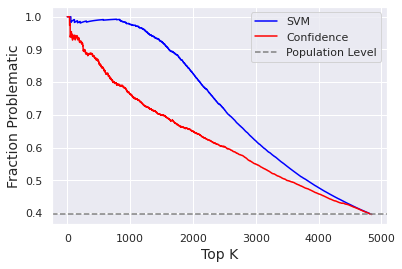

the max conf ind is problematic: True
the max dv ind is problematic: True


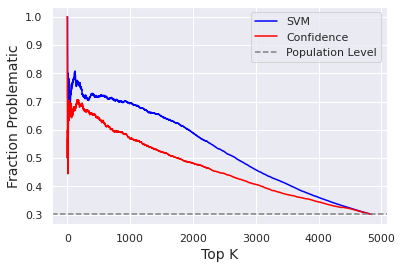

the max conf ind is problematic: False
the max dv ind is problematic: False


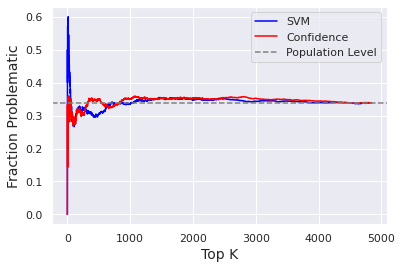

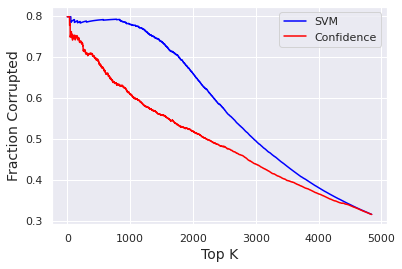

In [114]:
decision_vals = cbprocessor.metrics['test_metrics']['decision_values'] #svmout['test_metrics']['decision_values']
confidences = cbprocessor.run_dict['test']['confs']
is_problematic_gender = np.array((is_young & is_male) | (is_old & is_female))
is_problematic_hair = (blond_hair & is_male) | (not_blond & is_female)
# why do they ALWAYS start from 0??
dv_curves=[]
cf_curves=[]
for c in range(1):
    class_inds = (cbprocessor.run_dict['test']['ys'] == c)
    dv_curveg, cf_curveg = fraction_prob_plot(class_inds, decision_vals, confidences, is_problematic_gender, figname=f'imagenetc_class_{c}')
    dv_curveh, cf_curveh = fraction_prob_plot(class_inds, decision_vals, confidences, is_problematic_hair, figname=f'imagenetc_class_{c}')
    _, _ = fraction_prob_plot(class_inds, decision_vals, confidences, np.random.rand(19962) > (1 - is_problematic_gender.mean()), figname=f'imagenetc_class_{c}')
    
    # is it capturing it to a greater extent than just the gender already implies?
    # scale by how many females are NOT BLOND
    
    factor = 1 - 0.2024985710786315
    
    p=sns.lineplot(data=dv_curveg*factor, color='blue')
    p=sns.lineplot(data=cf_curveg*factor, color='red')
    #p.axhline(pop_level,color='grey',linestyle='dashed')
    p.set_xlabel('Top K', fontsize=14)
    p.set_ylabel('Fraction Corrupted', fontsize=14)

    plt.legend(labels=["SVM","Confidence", "Population Level"])
    #plt.savefig('figures/' + figname + '.pdf')
    plt.show()

    
    #dv_curves.append(dv_curve)
    #cf_curves.append(cf_curve)


## Varying ratios (CelebA)

-----------train_metrics--------------
{'Confusion Matrix': array([[ 6695,  1663],
       [ 9646, 26664]]),
 'Model Accuracy': 0.8128861825020148,
 'SVM Accuracy': 0.7468209862709045,
 'SVM Balanced Accuracy': 0.7676860690116882}
-----------val_metrics--------------
{'Confusion Matrix': array([[1321,  248],
       [1300, 4311]]),
 'Model Accuracy': 0.7814763231197771,
 'SVM Accuracy': 0.7844011187553406,
 'SVM Balanced Accuracy': 0.8051248788833618}
-----------test_metrics--------------
{'Confusion Matrix': array([[ 3264,  1218],
       [ 3511, 11969]]),
 'Model Accuracy': 0.7754733994589721,
 'SVM Accuracy': 0.7630999088287354,
 'SVM Balanced Accuracy': 0.7507187724113464}
Using default os_cache: False
Using default quasi_random: False
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Using default cmnist: False

-----------CONFIG--------------
{   '

100%|██████████| 447/447 [00:04<00:00, 89.48it/s] 


Accuracy 0.8137592673301697
---------set_device is True


100%|██████████| 72/72 [00:01<00:00, 51.49it/s]


Accuracy 0.7813370227813721
---------set_device is True


100%|██████████| 200/200 [00:01<00:00, 108.55it/s]


Accuracy 0.7754232883453369
Average CV score 0.6577999603460709
-----------train_metrics--------------
{'Confusion Matrix': array([[ 8226,  1636],
       [15318, 41822]]),
 'Model Accuracy': 0.8528103638697352,
 'SVM Accuracy': 0.7469627857208252,
 'SVM Balanced Accuracy': 0.783016175031662}
-----------val_metrics--------------
{'Confusion Matrix': array([[1414,  225],
       [1642, 3899]]),
 'Model Accuracy': 0.7717270194986072,
 'SVM Accuracy': 0.7399721741676331,
 'SVM Balanced Accuracy': 0.783192366361618}
-----------test_metrics--------------
{'Confusion Matrix': array([[ 3024,   852],
       [ 4254, 11832]]),
 'Model Accuracy': 0.8058310790501954,
 'SVM Accuracy': 0.7442139983177185,
 'SVM Balanced Accuracy': 0.7578660845756531}
Using default os_cache: False
Using default quasi_random: False
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Usin

100%|██████████| 671/671 [00:05<00:00, 125.39it/s]


Accuracy 0.8520491719245911
---------set_device is True


100%|██████████| 72/72 [00:01<00:00, 49.24it/s]


Accuracy 0.7717270255088806
---------set_device is True


100%|██████████| 200/200 [00:01<00:00, 104.85it/s]


Accuracy 0.8057810068130493
Average CV score 0.6490108576882387
-----------train_metrics--------------
{'Confusion Matrix': array([[ 4833,  1584],
       [12845, 46906]]),
 'Model Accuracy': 0.9030195865070729,
 'SVM Accuracy': 0.7819338440895081,
 'SVM Balanced Accuracy': 0.7690901160240173}
-----------val_metrics--------------
{'Confusion Matrix': array([[1540,  303],
       [1412, 3925]]),
 'Model Accuracy': 0.7433147632311977,
 'SVM Accuracy': 0.7611420750617981,
 'SVM Balanced Accuracy': 0.7855130136013031}
-----------test_metrics--------------
{'Confusion Matrix': array([[ 3154,  1192],
       [ 3138, 12478]]),
 'Model Accuracy': 0.782286344053702,
 'SVM Accuracy': 0.7830878496170044,
 'SVM Balanced Accuracy': 0.7623885273933411}
Using default os_cache: False
Using default quasi_random: False
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Usi

100%|██████████| 662/662 [00:04<00:00, 145.04it/s]


Accuracy 0.9024301767349243
---------set_device is True


100%|██████████| 72/72 [00:01<00:00, 36.78it/s]


Accuracy 0.7433147430419922
---------set_device is True


100%|██████████| 200/200 [00:01<00:00, 106.71it/s]


Accuracy 0.7824366092681885
Average CV score 0.6607415253657986
-----------train_metrics--------------
{'Confusion Matrix': array([[ 3388,  1425],
       [10866, 46351]]),
 'Model Accuracy': 0.9224085120103176,
 'SVM Accuracy': 0.8018539547920227,
 'SVM Balanced Accuracy': 0.7570091485977173}
-----------val_metrics--------------
{'Confusion Matrix': array([[1589,  283],
       [1597, 3711]]),
 'Model Accuracy': 0.7392757660167131,
 'SVM Accuracy': 0.738161563873291,
 'SVM Balanced Accuracy': 0.7739790976047516}
-----------test_metrics--------------
{'Confusion Matrix': array([[ 3216,  1042],
       [ 3265, 12439]]),
 'Model Accuracy': 0.786694719967939,
 'SVM Accuracy': 0.7842400670051575,
 'SVM Balanced Accuracy': 0.7736876904964447}
Using default os_cache: False
Using default quasi_random: False
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Usin

100%|██████████| 621/621 [00:04<00:00, 139.56it/s]


Accuracy 0.9222634434700012
---------set_device is True


100%|██████████| 72/72 [00:01<00:00, 49.39it/s]


Accuracy 0.7394150495529175
---------set_device is True


100%|██████████| 200/200 [00:01<00:00, 108.84it/s]


Accuracy 0.7865945100784302
Average CV score 0.6782661866726001
-----------train_metrics--------------
{'Confusion Matrix': array([[ 3440,  1848],
       [ 8184, 46084]]),
 'Model Accuracy': 0.9112096178386728,
 'SVM Accuracy': 0.8315535187721252,
 'SVM Balanced Accuracy': 0.7498612105846405}
-----------val_metrics--------------
{'Confusion Matrix': array([[1617,  273],
       [1600, 3690]]),
 'Model Accuracy': 0.7367688022284122,
 'SVM Accuracy': 0.7391365170478821,
 'SVM Balanced Accuracy': 0.7765490412712097}
-----------test_metrics--------------
{'Confusion Matrix': array([[ 2939,  1046],
       [ 3638, 12339]]),
 'Model Accuracy': 0.8003707043382426,
 'SVM Accuracy': 0.7653541564941406,
 'SVM Balanced Accuracy': 0.7549066841602325}
Using default os_cache: False
Using default quasi_random: False
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Us

100%|██████████| 596/596 [00:04<00:00, 140.45it/s]


Accuracy 0.910689115524292
---------set_device is True


100%|██████████| 72/72 [00:01<00:00, 52.09it/s]


Accuracy 0.7367687821388245
---------set_device is True


100%|██████████| 200/200 [00:01<00:00, 111.76it/s]


Accuracy 0.8003706932067871
Average CV score 0.699834165977189
-----------train_metrics--------------
{'Confusion Matrix': array([[ 2511,  1845],
       [ 6809, 46725]]),
 'Model Accuracy': 0.9247538434962861,
 'SVM Accuracy': 0.8505095839500427,
 'SVM Balanced Accuracy': 0.7246280610561371}
-----------val_metrics--------------
{'Confusion Matrix': array([[1721,  310],
       [1543, 3606]]),
 'Model Accuracy': 0.7171309192200557,
 'SVM Accuracy': 0.7419220209121704,
 'SVM Balanced Accuracy': 0.7738479971885681}
-----------test_metrics--------------
{'Confusion Matrix': array([[ 3085,   926],
       [ 3108, 12843]]),
 'Model Accuracy': 0.799068229636309,
 'SVM Accuracy': 0.797916054725647,
 'SVM Balanced Accuracy': 0.7871440947055817}
Using default os_cache: False
Using default quasi_random: False
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Using

100%|██████████| 579/579 [00:04<00:00, 140.24it/s]


Accuracy 0.9243738055229187
---------set_device is True


100%|██████████| 72/72 [00:01<00:00, 51.74it/s]


Accuracy 0.716991662979126
---------set_device is True


100%|██████████| 200/200 [00:02<00:00, 75.83it/s] 


Accuracy 0.7991183400154114
Average CV score 0.708173865000897
-----------train_metrics--------------
{'Confusion Matrix': array([[ 1409,  1249],
       [ 7568, 46494]]),
 'Model Accuracy': 0.9531382228490832,
 'SVM Accuracy': 0.8445521593093872,
 'SVM Balanced Accuracy': 0.695055216550827}
-----------val_metrics--------------
{'Confusion Matrix': array([[1795,  314],
       [1747, 3324]]),
 'Model Accuracy': 0.7062674094707521,
 'SVM Accuracy': 0.7129526734352112,
 'SVM Balanced Accuracy': 0.7533031404018402}
-----------test_metrics--------------
{'Confusion Matrix': array([[ 3402,   899],
       [ 3602, 12059]]),
 'Model Accuracy': 0.7845406271916642,
 'SVM Accuracy': 0.7745215892791748,
 'SVM Balanced Accuracy': 0.78049036860466}
Using default os_cache: False
Using default quasi_random: False
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Using 

100%|██████████| 568/568 [00:04<00:00, 135.41it/s]


Accuracy 0.9523977637290955
---------set_device is True


100%|██████████| 72/72 [00:01<00:00, 50.81it/s]


Accuracy 0.7062674164772034
---------set_device is True


100%|██████████| 200/200 [00:02<00:00, 71.25it/s] 


Accuracy 0.7845406532287598
Average CV score 0.7187688646485397
-----------train_metrics--------------
{'Confusion Matrix': array([[ 1664,  1734],
       [ 5946, 46474]]),
 'Model Accuracy': 0.9391235802071016,
 'SVM Accuracy': 0.8624099493026733,
 'SVM Balanced Accuracy': 0.6881349235773087}
-----------val_metrics--------------
{'Confusion Matrix': array([[1852,  280],
       [1671, 3377]]),
 'Model Accuracy': 0.7030640668523677,
 'SVM Accuracy': 0.7282729744911194,
 'SVM Balanced Accuracy': 0.7688228487968445}
-----------test_metrics--------------
{'Confusion Matrix': array([[ 3337,   870],
       [ 3581, 12174]]),
 'Model Accuracy': 0.7892495741909629,
 'SVM Accuracy': 0.777026355266571,
 'SVM Balanced Accuracy': 0.7829544544219971}
Using default os_cache: False
Using default quasi_random: False
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Usi

100%|██████████| 559/559 [00:04<00:00, 138.80it/s]


Accuracy 0.9375649690628052
---------set_device is True


100%|██████████| 72/72 [00:01<00:00, 52.10it/s]


Accuracy 0.7029247879981995
---------set_device is True


100%|██████████| 200/200 [00:01<00:00, 106.42it/s]


Accuracy 0.78924959897995
Average CV score 0.7363833727497083


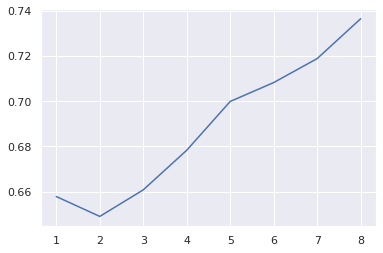

In [25]:
# look at validation error
celeba_cv_vals=[]
celeba_validation_model_accs = []
processors=[]
for corr in range(1,9):
        
    ptname = '/home/gridsan/hanlaw/CorrelatedErrors/' + f'celeba_age_normalized_svm_1_{corr}.pt'
    with open(ptname, 'rb') as f:
        svmout = torch.load(f)
        
        
        model_ckpt = f'/home/gridsan/hanlaw/CorrelatedErrors/runs/celeba_age_int_base_1_{corr}/version_0/checkpoints/checkpoint_last.pt'
         #os.path.join(experiment_root, "celeba/loss_vec_files")

        processor = viz_utils.SVMProcessor(ptname, root=beton_root, checkpoint_path=model_ckpt, set_device=True, spurious=True)
        processors.append(processor)
        
        celeba_cv_vals.append(process_svm_out(svmout))
        celeba_validation_model_accs.append(svmout['val_metrics']['ytrue'].mean())
plt.plot(range(1,9),celeba_cv_vals)

In [23]:
svmout['test_metrics']

{'accuracy': 0.777026355266571,
 'balanced_accuracy': 0.7829544544219971,
 'confusion_matrix': array([[ 3337,   870],
        [ 3581, 12174]]),
 'indiv_accs': {'accuracy': array([0.77083331, 0.77901286]),
  'balanced_accuracy': array([0.78659996, 0.78035429])},
 'ytrue': array([1, 1, 1, ..., 1, 1, 1]),
 'ypred': array([0, 1, 1, ..., 0, 1, 1]),
 'decision_values': array([-0.29225724,  0.3592438 ,  0.46091655, ..., -0.59013938,
         0.65086896,  0.44645652]),
 'classes': array([0, 1, 1, ..., 1, 1, 1]),
 'skipped_classes': [],
 'spuriouses': None,
 'indices': array([    0,     1,     2, ..., 19959, 19960, 19961])}

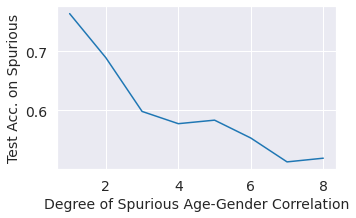

In [35]:
test_accs = []
spur_accs = []
for ind, processor in enumerate(processors):
    # accuracy on spurious ones?
    test_accs.append((processor.run_dict['test']['preds'] == processor.run_dict['test']['ys']).mean())
    males = processor.run_dict['test']['spuriouses'].astype('bool')
    youngs = processor.run_dict['test']['ys'].astype('bool')
    #print('males',males,'youngs',youngs)
    true_spurs = (males & youngs) | (np.logical_not(males) & np.logical_not(youngs))
    #print('true_spurs', true_spurs, true_spurs.sum(), true_spurs.mean())
    sa = (processor.run_dict['test']['preds'][true_spurs] == processor.run_dict['test']['ys'][true_spurs]).mean()
    spur_accs.append(sa)
    
    pklname = '/home/gridsan/hanlaw/CorrelatedErrors/' + f'celeba_age_normalized_svm_1_{ind+1}_model.pkl'
    #processor._redo_svm(pklname)
    #print(processor.redo_svm['test']['test_metrics']['spuriouses'])
    
    
import pandas as pd
df = pd.DataFrame()
df['Degree of Spurious Age-Gender Correlation'] = range(1,9)
df['Test Acc. on Spurious'] = spur_accs

p = sns.lineplot(data=df, x='Degree of Spurious Age-Gender Correlation', y='Test Acc. on Spurious', color=BLUE)
plt.savefig("celeba_varying_test_spur_acc.pdf", bbox_inches='tight')
plt.show()


#plt.plot(spur_accs)


In [19]:
processor.run_dict['test']

{'preds': array([0, 1, 0, ..., 0, 0, 1]),
 'ys': array([0, 1, 1, ..., 1, 1, 1]),
 'spuriouses': None,
 'latents': array([[1.639e+00, 1.367e+00, 1.168e+00, ..., 1.295e+00, 1.295e+00,
         1.712e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 3.302e-02,
         0.000e+00],
        [0.000e+00, 2.715e-02, 7.420e-03, ..., 0.000e+00, 3.430e-02,
         6.252e-03],
        ...,
        [3.787e-02, 0.000e+00, 8.069e-02, ..., 1.360e-02, 0.000e+00,
         4.700e-02],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 6.509e-04, 6.763e-02,
         1.994e-02],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 4.935e-02, 2.406e-02,
         0.000e+00]], dtype=float16),
 'confs': array([0.99999833, 0.5181595 , 0.29905403, ..., 0.47747803, 0.4878116 ,
        0.8240375 ], dtype=float32),
 'indices': array([    0,     1,     2, ..., 19959, 19960, 19961])}

In [12]:
(processor.run_dict['test']['preds'] == processor.run_dict['test']['ys']).mean()

0.7892495741909629

In [14]:
processor.run_dict['test'].keys()

dict_keys(['preds', 'ys', 'spuriouses', 'latents', 'confs', 'indices'])

In [61]:
svmout['train_metrics']['accuracy']

0.8624099493026733

In [33]:
sns.set()
BLUE = sns.color_palette("tab10")[0]
RED = sns.color_palette("tab10")[3]
ORANGE = sns.color_palette("tab10")[1]
BROWN = sns.color_palette("tab10")[5]
GRAY = sns.color_palette("tab10")[7]
GREEN = sns.color_palette("tab10")[2]

import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
          'figure.figsize': (5, 3),
         'axes.labelsize': 14,
         'axes.titlesize':16,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
pylab.rcParams.update(params)

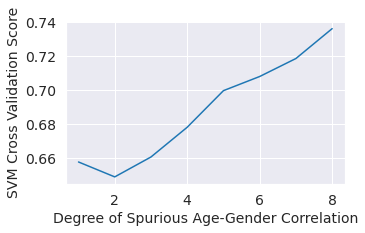

'p = sns.lineplot(range(1,9),celeba_cv_vals, color=BLUE)\n#p = sns.lineplot(range(1,9),celeba_validation_model_accs, color=GREEN)\n\nplt.xlabel(\'Degree of Spurious Age-Gender Correlation\')\nplt.ylabel(\'SVM Cross Validation Score\')\nplt.show() \nfig = p.get_figure()\nfig.savefig("celeba_cv_plot.pdf")\n#plt.savefig("celeba_cv_plot.pdf")\n#\n\n#fig = p.get_figure()\n#fig.savefig("celeba_cv_plot.pdf") \n\n#plt.show()\n\n#p.savefig(\'celeba_cv_plot.pdf\')'

In [60]:
import pandas as pd
df = pd.DataFrame()
df['Degree of Spurious Age-Gender Correlation'] = range(1,9)
df['SVM Cross Validation Score'] = celeba_cv_vals

p = sns.lineplot(data=df, x='Degree of Spurious Age-Gender Correlation', y='SVM Cross Validation Score', color=BLUE)
plt.savefig("celeba_cv_plot.pdf", bbox_inches='tight')
plt.show()



In [20]:
svmout['val_metrics'].keys()

dict_keys(['accuracy', 'balanced_accuracy', 'confusion_matrix', 'indiv_accs', 'ytrue', 'ypred', 'decision_values', 'classes', 'skipped_classes', 'spuriouses', 'indices'])

In [21]:
svmout['val_metrics']['accuracy']

0.7282729744911194

In [22]:
(svmout['val_metrics']['ytrue'] == svmout['val_metrics']['ypred']).mean()

0.7282729805013928

In [23]:
svmout['val_metrics']['ytrue'].mean()

0.7030640668523677

# Imagenet-C

In [6]:
name = "imagenet_c_base_svm.pt" # SVM output file
model_ckpt = f"/home/gridsan/hanlaw/CorrelatedErrors/runs/imagenet_c_base/version_0/checkpoints/checkpoint_last.pt"

imgcprocessor = viz_utils.SVMProcessor(name, root=beton_root, checkpoint_path=model_ckpt, set_device=True, spurious=True)

-----------train_metrics--------------
{'Confusion Matrix': array([[244973, 121021],
       [151853, 506998]]),
 'Model Accuracy': 0.6428786792149057,
 'SVM Accuracy': 0.7337412238121033,
 'SVM Balanced Accuracy': 0.7194272577762604}
-----------val_metrics--------------
{'Confusion Matrix': array([[107224,  18087],
       [ 19217, 111746]]),
 'Model Accuracy': 0.5110272598859034,
 'SVM Accuracy': 0.8544370532035828,
 'SVM Balanced Accuracy': 0.854463517665863}
-----------test_metrics--------------
{'Confusion Matrix': array([[18302,  7260],
       [ 6809, 17626]]),
 'Model Accuracy': 0.48872932375942557,
 'SVM Accuracy': 0.7186031341552734,
 'SVM Balanced Accuracy': 0.7186634838581085}
Using default os_cache: False
Using default quasi_random: False
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default val_beton: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Using default cmnist: Fa

100%|██████████| 10249/10249 [02:21<00:00, 72.33it/s]


Accuracy 0.6430679559707642
---------set_device is True


100%|██████████| 2563/2563 [00:30<00:00, 83.49it/s]


Accuracy 0.511003851890564
---------set_device is True


100%|██████████| 500/500 [00:09<00:00, 54.07it/s]


Accuracy 0.4888093173503876


In [17]:
imgcprocessor.metrics.keys()

dict_keys(['args', 'stats', 'cv_scores', 'train_metrics', 'predicted_train_errors', 'val_metrics', 'predicted_val_errors', 'test_metrics', 'predicted_test_errors'])

In [21]:
imgcprocessor.metrics['train_metrics'].keys()

dict_keys(['accuracy', 'balanced_accuracy', 'confusion_matrix', 'indiv_accs', 'ytrue', 'ypred', 'decision_values', 'classes', 'skipped_classes', 'spuriouses', 'indices'])

In [22]:
(imgcprocessor.metrics['train_metrics']['ytrue'] == imgcprocessor.metrics['train_metrics']['ypred']).mean()

0.7337411998887636

In [23]:
imgcprocessor.metrics['train_metrics']['accuracy']

0.7337412238121033

In [27]:
(imgcprocessor.metrics['val_metrics']['ytrue']).mean()

0.5110272598859034

In [29]:
(imgcprocessor.run_dict['test']['ys'] == imgcprocessor.run_dict['test']['preds']).mean()

0.4888093285597136

In [30]:
imgcprocessor.run_dict['test']['spuriouses']

array([0, 0, 0, ..., 1, 1, 1])

In [31]:
for st in ['val', 'test']:
    spur_inds = imgcprocessor.run_dict[st]['spuriouses'].astype('bool')
    acc_on_spurr = (imgcprocessor.run_dict[st]['ys'][spur_inds] == \
                    imgcprocessor.run_dict[st]['preds'][spur_inds]).mean()
    print('Accuracy on spurious', st, acc_on_spurr)
    
    
    
    
    

Accuracy on spurious val 0.45414476501966283
Accuracy on spurious test 0.4295701084773001


In [15]:
out=svm_utils.evaluate_loader((imgcprocessor.loaders['test']), imgcprocessor._build_model(model_ckpt))

{'training_args': {'epochs': 16, 'lr': 0.5, 'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005}, 'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoch': 2}, 'iters_per_epoch': 1000}, 'epoch': 15, 'training_metrics': {'loss': 1.6795536632537842, 'acc': 0.606451171875}, 'val_metrics': {'loss': 2.140437711106386, 'acc': 0.5110272598891595}}
---------set_device is False


100%|██████████| 500/500 [00:05<00:00, 84.94it/s]

Accuracy 0.4888093173503876


----CLASS: 0 



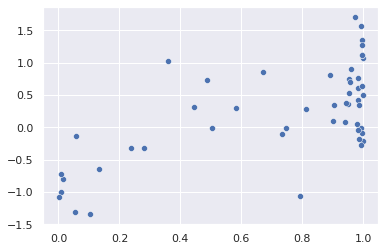

---- CONFIDENCE ------


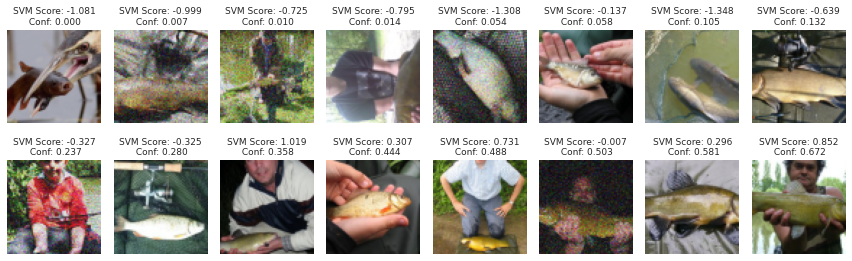

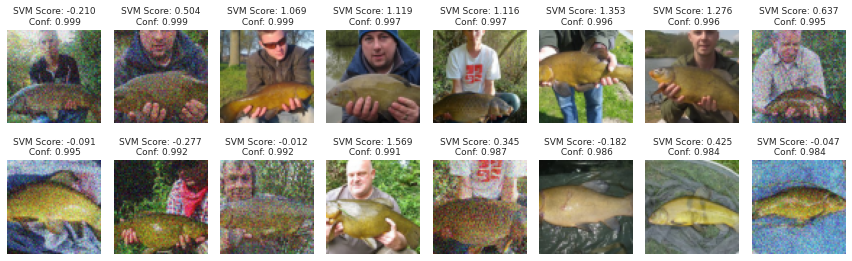

---- SVM ------


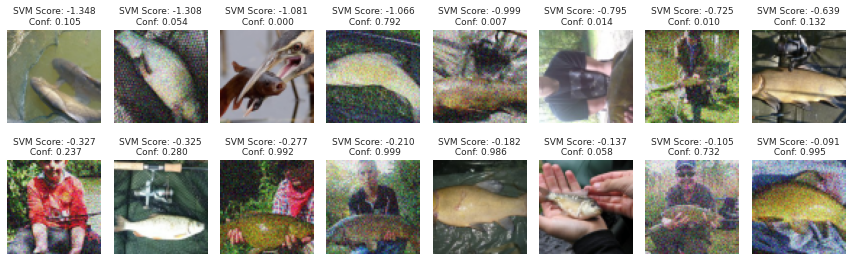

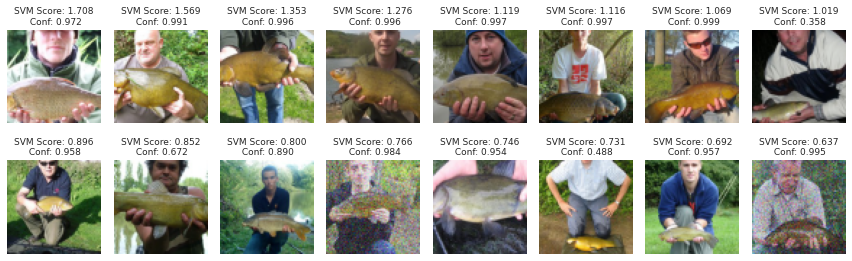

In [35]:
for c in range(1): #this only shows two of the classes! 
    print('----CLASS:',c,'\n')
    imgcprocessor.display_extremes(c, split='test', show_images=True, savename=f'imgc_c{c}')

In [9]:
decision_vals = imgcprocessor.metrics['test_metrics']['decision_values'] #svmout['test_metrics']['decision_values']
confidences = imgcprocessor.run_dict['test']['confs']
is_problematic = imgcprocessor.run_dict['test']['spuriouses']
# why do they ALWAYS start from 0??
dv_curves=[]
cf_curves=[]
for c in range(1000):
    class_inds = (imgcprocessor.run_dict['test']['ys'] == c)
    if (class_inds.sum()) != 50:
        print('NOT 50 examples', c)
    dv_curve, cf_curve = fraction_prob_plot(class_inds, decision_vals, confidences, \
                                            is_problematic, figname=f'imagenetc_class_{c}',doplot=False)
    
    dv_curves.append(dv_curve)
    cf_curves.append(cf_curve)


NOT 50 examples 29
NOT 50 examples 388
NOT 50 examples 624


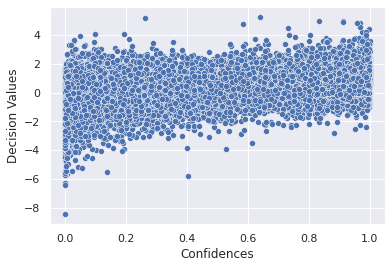

In [10]:
plt.figure()
p=sns.scatterplot(x=confidences, y=decision_vals)
p.set_xlabel('Confidences')
p.set_ylabel('Decision Values')
plt.savefig('figures/imagenetc_confs_vs_dvs.pdf', bbox_inches='tight')
plt.show()

In [12]:
bad_inds = []
for (ind,el) in enumerate(dv_curves):
    if len(el) != 49:
        print(ind)
        bad_inds.append(ind)


29
388
624


In [13]:
bad_inds.reverse()

In [14]:
for bi in bad_inds:
    dv_curves.pop(bi)
for bi in bad_inds:
    cf_curves.pop(bi)

In [2]:
dv_curves

NameError: name 'dv_curves' is not defined

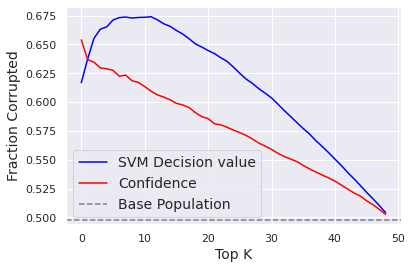

In [15]:
p=sns.lineplot(data=np.mean(np.array(dv_curves), 0), color='blue')
p=sns.lineplot(data=np.mean(np.array(cf_curves), 0), color='red')
p.axhline(is_problematic.mean(),color='grey',linestyle='dashed')
p.set_xlabel('Top K', fontsize=14)
p.set_ylabel('Fraction Corrupted', fontsize=14)

plt.legend(labels=["SVM Decision value","Confidence", "Base Population"],fontsize=14)
plt.savefig('figures/imagenetc_frack.pdf', bbox_inches='tight')
plt.show()
